In [89]:
import arviz
import pyro
import torch
import numpy as np
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
from torch.distributions import constraints
from scipy.stats import multivariate_normal

In [90]:
!mkdir images

mkdir: images: File exists


In [91]:
# The function
g = lambda x: (-(np.sin(6*torch.pi*x))**2) + 6*(x**2) - 5*(x**4) + (3/2)

In [92]:
# create dataset
SIZE = 30
X = torch.linspace(0, 1, SIZE)
y = g(X) + np.random.normal(scale = 0.01, size = (SIZE,))
choose = np.random.choice(SIZE, int(SIZE * 2/3), replace= False)
non_choosen = np.setdiff1d(np.arange(SIZE), choose)
X_train, X_test = X[choose], X[non_choosen]
y_train, y_test = y[choose], y[non_choosen]

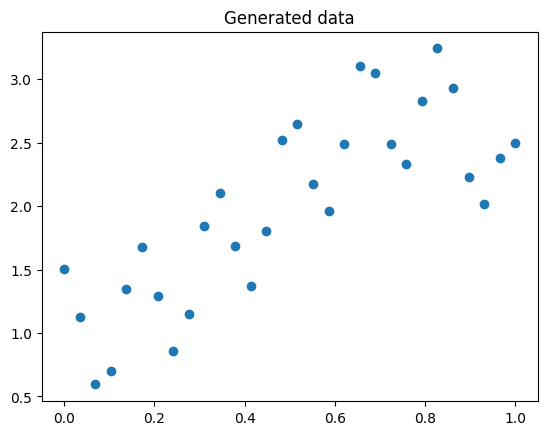

In [93]:
plt.scatter(X, y)
plt.title("Generated data")
plt.show()
plt.close()

Visually inspecting the dataset shows that there is a general upwards trend, and a periodicity around this trend. 

Thus, we have chosen sum an RBF kernel and a Periodic kernel, hoping that the first will model the overall trend, and the latter will capture the periodicity. We fix the variance at 1.0 for both kernels too allow faster training.

Inspired from https://pyro.ai/examples/gp.html
and https://pyro.ai/examples/mle_map.html

In [94]:
# function for creating the GPRegression object with priors

def gen_model(priors = True, period = torch.tensor(1.), lengthPer = torch.tensor(1.), 
              lengthRBF = torch.tensor(1.), varPer = torch.tensor(1.), varRBF= torch.tensor(1.)):
    
    # defining kernels
    periodic = gp.kernels.Periodic(input_dim=1, period=period, lengthscale=lengthPer, variance=varPer)
    rbf = gp.kernels.RBF(input_dim=1, lengthscale=lengthRBF, variance=varRBF)
    k = gp.kernels.Sum(kern0=rbf, kern1=periodic)

    model = gp.models.GPRegression(
        X=X_train,
        y=y_train,
        kernel=k,
        noise= torch.tensor(0.1),
    )
    if priors == True: 
        # RBF Kernel               
        model.kernel.kern0.variance_unconstrained.detach_()
        model.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.5))
        # Periodic Kernel
        model.kernel.kern1.variance_unconstrained.detach_()
        model.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
        model.kernel.kern1.period = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
            
    return model

In [95]:
# training the model to find MAP-estimates

def train_model(model, print_map = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000 
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(model.model, model.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if print_map == True:
        model.set_mode("guide")
        # MAP
        # print(f"Linear, Variance: {model.kernel.kern0.variance.item()}\n")

        print(f"RBF, Variance: {model.kernel.kern0.variance.item()}")
        print(f"RBF, Lengthscale: {model.kernel.kern0.lengthscale.item()}\n")
        print(f"Periodic Kernel, Variance: {model.kernel.kern1.variance.item()}")
        print(f"Periodic Kernel, Lengthscale: {model.kernel.kern1.lengthscale.item()}\n")
        print(f"Periodic Kernel, Period: {model.kernel.kern1.period.item()}")
        print(f"Noise: {model.noise.item()}")
    
    return model

In [96]:
# plotting model predictions
def plot_model(model, X_train, X_test, y_train, y_test):
    plt.scatter(X_test, y_test, label = "Test data")
    plt.scatter(X_train, y_train, label = "Training data")
    x_space = np.linspace(0, 1, 300)
    y_space = g(x_space)
    plt.plot(x_space, y_space, label = "G(x)")
    with torch.no_grad():
        mean, var = model(X_test, noiseless = False) # a.k.a posterior predictive
    plt.plot(X_test, mean, color="C3", label = "Predictions")
    plt.scatter(X_test, mean, color = "C3", s = 2, )
    plt.fill_between(X_test, (mean + 1.95*var.sqrt()), (mean - 1.95*var.sqrt()), alpha = 0.1, color = "C0")
    plt.legend()


In [97]:
# calculate posterior likelihood on test data with trained model/MAP estimates
def MAP_likelihood(model, X_test, y_test):
    with torch.no_grad():
        mean, cov = model(X_test, full_cov = True, noiseless = False)
    return multivariate_normal.pdf(y_test, mean, cov)

In [98]:
# train GP model using MCMC to allow sampling from posterior for parameters
def MCMC(model, i = 0):
    nuts_kernel = pyro.infer.NUTS(model.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=250, num_chains=2, warmup_steps=100)
    mcmc.run()

    data = arviz.from_pyro(mcmc)
    summary = arviz.summary(data)
    print(summary)

    arviz.plot_posterior(data)
    plt.tight_layout()
    plt.savefig(f"./images/nuts_posterior_{i}.png")
    plt.close()
    arviz.plot_trace(data)
    plt.tight_layout()
    plt.savefig(f"./images/nuts_trace_{i}.png")
    plt.close()
    samples = mcmc.get_samples()

    return samples

# calculate posterior likelihood of test data using samples from posterior on parameters
def NUTS_likelihood(model, X_test, y_test, n_samples = 500, i = 0):
    samples = MCMC(model, i)
    plot_model(model, X_train, X_test, y_train, y_test)
    plt.tight_layout()
    plt.savefig("./images/nuts_predictions_" + str(i) + ".png")
    plt.close()
    posterior_predictive = []
    
    for i in range(n_samples):
        pyro.clear_param_store()
        fixed_model = gen_model(
            priors = False,
            lengthRBF=samples['kernel.kern0.lengthscale'][i], 
            lengthPer=samples['kernel.kern1.lengthscale'][i],
            period=samples["kernel.kern1.period"][i]
            )

        with torch.no_grad():
            mean, cov = fixed_model(X_test, full_cov=True, noiseless = False)
            posterior_predictive.append((mean, cov))
            
    likelihood = [multivariate_normal.pdf(y_test, mean, cov) for mean, cov in posterior_predictive]
    likelihood = torch.mean(torch.tensor(likelihood))
    
    return likelihood

In [99]:
map_likelihood_collection = []
nuts_likelihood_collection = []

for i in range(20):    
    # create dataset
    X = torch.linspace(0, 1, SIZE)
    y = g(X) + np.random.normal(scale = 0.01, size = (SIZE,))
    choose = np.random.choice(SIZE, int(SIZE * 2/3), replace= False)
    non_choosen = np.setdiff1d(np.arange(SIZE), choose)
    X_train, X_test = X[choose], X[non_choosen]
    y_train, y_test = y[choose], y[non_choosen]
    
    # train MAP model
    pyro.clear_param_store()
    model1 = gen_model()
    train_model(model1)
    plot_model(model1, X_train, X_test, y_train, y_test)
    plt.tight_layout()
    plt.savefig("./images/map_predictions_" + str(i) + ".png")
    plt.close()
    map_likelihood = MAP_likelihood(model1, X_test, y_test)
    
    #train NUTS model
    pyro.clear_param_store()
    model2 = gen_model()
    nuts_likelihood = NUTS_likelihood(model2, X_test, y_test, i = i)
    
    map_likelihood_collection.append(map_likelihood)
    nuts_likelihood_collection.append(nuts_likelihood.item())

Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.680  0.240   0.309    1.096      0.022    0.016   
kernel.kern1.lengthscale  0.939  0.311   0.433    1.542      0.066    0.047   
kernel.kern1.period       0.376  0.101   0.300    0.656      0.055    0.043   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     116.0     167.0   1.01  
kernel.kern1.lengthscale      15.0      59.0   1.10  
kernel.kern1.period            6.0      37.0   1.33  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.655  0.201   0.312    0.991      0.012    0.008   
kernel.kern1.lengthscale  0.954  0.284   0.441    1.484      0.015    0.011   
kernel.kern1.period       0.337  0.009   0.320    0.353      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     276.0     317.0   1.00  
kernel.kern1.lengthscale     365.0     314.0   1.00  
kernel.kern1.period          410.0     282.0   1.01  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.604  0.199   0.321    0.977      0.010    0.007   
kernel.kern1.lengthscale  0.826  0.288   0.386    1.445      0.113    0.084   
kernel.kern1.period       0.415  0.082   0.322    0.521      0.057    0.047   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     506.0     439.0   1.01  
kernel.kern1.lengthscale       6.0      69.0   1.29  
kernel.kern1.period            3.0     159.0   1.84  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.592  0.172   0.327    0.931      0.010    0.007   
kernel.kern1.lengthscale  0.985  0.276   0.483    1.487      0.014    0.010   
kernel.kern1.period       0.338  0.009   0.323    0.358      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     330.0     236.0   1.01  
kernel.kern1.lengthscale     384.0     275.0   1.00  
kernel.kern1.period          316.0     223.0   1.01  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_ten

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.622  0.189   0.329    0.960      0.013    0.009   
kernel.kern1.lengthscale  0.981  0.380   0.318    1.640      0.033    0.024   
kernel.kern1.period       0.316  0.058   0.166    0.356      0.022    0.016   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     231.0     254.0   1.01  
kernel.kern1.lengthscale     116.0      80.0   1.01  
kernel.kern1.period           16.0      12.0   1.09  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.793  0.434   0.266    1.493      0.081    0.058   
kernel.kern1.lengthscale  0.781  0.295   0.283    1.295      0.113    0.084   
kernel.kern1.period       0.584  0.352   0.318    1.185      0.184    0.142   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale      36.0     130.0   1.04  
kernel.kern1.lengthscale       6.0     103.0   1.24  
kernel.kern1.period            3.0      77.0   1.83  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.597  0.188   0.256    0.916      0.010    0.007   
kernel.kern1.lengthscale  0.986  0.298   0.445    1.497      0.015    0.010   
kernel.kern1.period       0.337  0.011   0.321    0.363      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     380.0     315.0   1.01  
kernel.kern1.lengthscale     378.0     320.0   1.01  
kernel.kern1.period          375.0     269.0   1.01  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_ten

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.656  0.207   0.324    1.045      0.012    0.009   
kernel.kern1.lengthscale  0.836  0.250   0.424    1.343      0.086    0.063   
kernel.kern1.period       0.421  0.086   0.321    0.527      0.059    0.050   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     304.0     235.0   1.01  
kernel.kern1.lengthscale      10.0     131.0   1.16  
kernel.kern1.period            3.0     144.0   1.83  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.601  0.178   0.284    0.923      0.011    0.008   
kernel.kern1.lengthscale  0.665  0.174   0.292    0.957      0.012    0.009   
kernel.kern1.period       0.502  0.014   0.475    0.527      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     271.0     229.0   1.01  
kernel.kern1.lengthscale     190.0     114.0   1.01  
kernel.kern1.period          476.0     352.0   1.00  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.728  0.255   0.322    1.225      0.020    0.014   
kernel.kern1.lengthscale  0.758  0.257   0.330    1.223      0.087    0.063   
kernel.kern1.period       0.509  0.182   0.322    0.710      0.121    0.100   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     157.0     232.0   1.00  
kernel.kern1.lengthscale      10.0      94.0   1.15  
kernel.kern1.period            3.0      60.0   1.87  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.594  0.179   0.281    0.910      0.009    0.006   
kernel.kern1.lengthscale  0.957  0.265   0.482    1.444      0.012    0.008   
kernel.kern1.period       0.333  0.007   0.318    0.345      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     447.0     226.0   1.01  
kernel.kern1.lengthscale     451.0     251.0   1.00  
kernel.kern1.period          321.0     240.0   1.00  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Convert

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.655  0.195   0.303    0.983      0.017    0.012   
kernel.kern1.lengthscale  0.940  0.284   0.436    1.498      0.078    0.057   
kernel.kern1.period       0.297  0.112   0.154    0.357      0.029    0.021   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     126.0     245.0   1.02  
kernel.kern1.lengthscale      14.0      61.0   1.12  
kernel.kern1.period           10.0      11.0   1.45  


Warmup [1]:   0%|          | 0/350 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/350 [00:00, ?it/s]

/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/lucaskrieger/Documents/NLP-Project/NLP-Assignment/.conda/lib/python3.10/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Co

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.kern0.lengthscale  0.673  0.194   0.368    1.045      0.015    0.011   
kernel.kern1.lengthscale  0.762  0.415   0.241    1.554      0.084    0.060   
kernel.kern1.period       0.334  0.170   0.129    0.521      0.119    0.100   

                          ess_bulk  ess_tail  r_hat  
kernel.kern0.lengthscale     194.0     313.0   1.08  
kernel.kern1.lengthscale      17.0      17.0   1.20  
kernel.kern1.period            3.0      12.0   1.92  


In [ ]:
map_likelihood_collection
print(f"Mean {np.mean(map_likelihood_collection):.3f}, SD {np.std(map_likelihood_collection):.3f}")

Mean 24872592170.182, SD 69308415580.108


In [ ]:
nuts_likelihood_collection
print(f"Mean {np.mean(nuts_likelihood_collection):.3f}, SD {np.std(nuts_likelihood_collection):.3f}")

Mean 0.276, SD 0.146


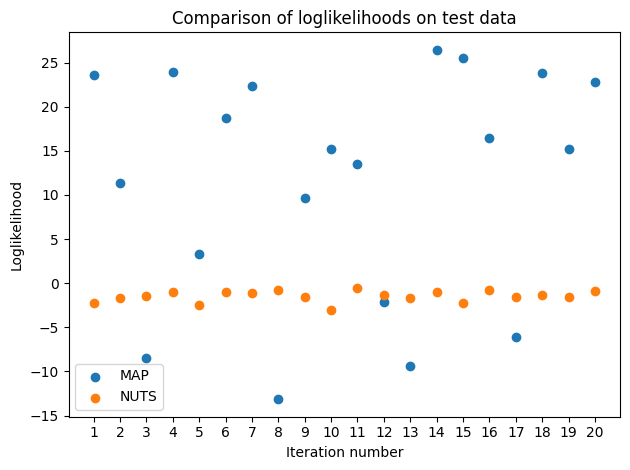

In [ ]:
plt.scatter(range(1, 21), np.log(map_likelihood_collection), label = "MAP")
plt.scatter(range(1, 21), np.log(nuts_likelihood_collection), label = "NUTS")
plt.ylabel("Loglikelihood")
plt.xlabel("Iteration number")
plt.xticks(range(1, 21))
plt.title("Comparison of loglikelihoods on test data")
plt.tight_layout()
plt.savefig("Likelihood_comparison.png")
plt.legend()
plt.show()